Lade Kohorte mit Schweregraden...


C:\Users\Simon\AppData\Local\Temp\ipykernel_38236\2374278748.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='intervention_dialysis', y='max_creatinine', data=df, palette=['skyblue', 'orange'])


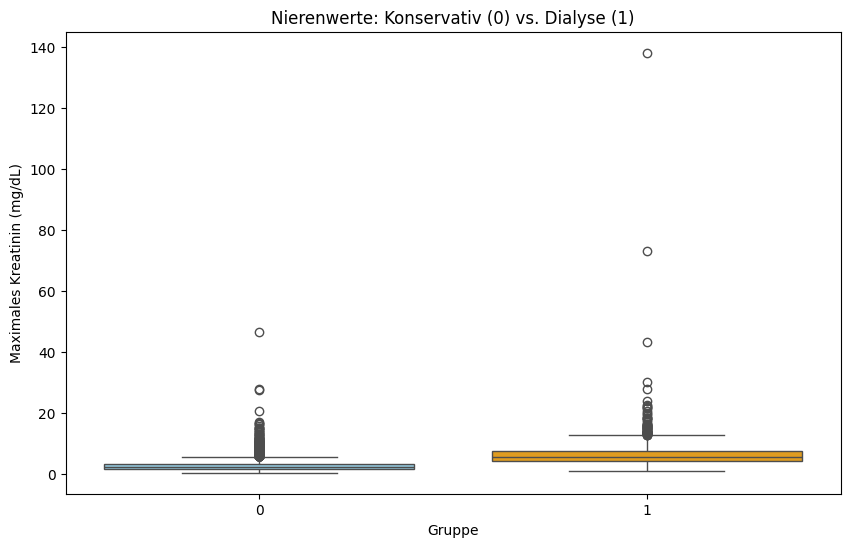

Schwerkranke (Krea > 4) OHNE Dialyse: 1359
Schwerkranke (Krea > 4) MIT  Dialyse: 981


,Gruppe,Sterblichkeit (%)
0,Ohne Dialyse (Schwer),31.788079
1,Mit Dialyse (Schwer),29.357798


In [15]:
import sys
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('..'))
from src.db_connect import load_sql

# 1. Daten laden (mit den neuen Features)
print("Lade Kohorte mit Schweregraden...")
df = load_sql('../sql/add_severity.sql')

# 2. Visualisierung: Kreatinin-Werte vergleichen
plt.figure(figsize=(10, 6))
sns.boxplot(x='intervention_dialysis', y='max_creatinine', data=df, palette=['skyblue', 'orange'])
plt.title('Nierenwerte: Konservativ (0) vs. Dialyse (1)')
plt.ylabel('Maximales Kreatinin (mg/dL)')
plt.xlabel('Gruppe')
plt.show()

# 3. Die entscheidende Frage:
# Gibt es Patienten OHNE Dialyse, die aber SEHR KRANK waren (Kreatinin > 5)?
schwere_ohne_dialyse = df[ (df['intervention_dialysis'] == 0) & (df['max_creatinine'] > 4.0) ]
schwere_mit_dialyse  = df[ (df['intervention_dialysis'] == 1) & (df['max_creatinine'] > 4.0) ]

print(f"Schwerkranke (Krea > 4) OHNE Dialyse: {len(schwere_ohne_dialyse)}")
print(f"Schwerkranke (Krea > 4) MIT  Dialyse: {len(schwere_mit_dialyse)}")

# 4. Sterblichkeit in dieser "Hochrisiko-Gruppe" vergleichen
comparison = pd.DataFrame({
    'Gruppe': ['Ohne Dialyse (Schwer)', 'Mit Dialyse (Schwer)'],
    'Sterblichkeit (%)': [
        schwere_ohne_dialyse['outcome_death'].mean() * 100,
        schwere_mit_dialyse['outcome_death'].mean() * 100
    ]
})
display(comparison)

In [16]:
# ... (Ihr vorheriger Code zum Laden von df muss gelaufen sein) ...

# Falls df nicht mehr im Speicher ist, laden wir es sicherheitshalber neu:
# df = load_sql('../sql/add_severity.sql')

# 1. Filtern der schweren Fälle (Kreatinin > 4)
schwere_ohne_dialyse = df[ (df['intervention_dialysis'] == 0) & (df['max_creatinine'] > 4.0) ]
schwere_mit_dialyse  = df[ (df['intervention_dialysis'] == 1) & (df['max_creatinine'] > 4.0) ]

# 2. Berechnung der Statistik
stats_vergleich = pd.DataFrame({
    'Gruppe': ['Ohne Dialyse (Schwer)', 'Mit Dialyse (Schwer)'],
    
    'Anzahl (N)': [
        len(schwere_ohne_dialyse),
        len(schwere_mit_dialyse)
    ],
    
    'Sterblichkeit (%)': [
        round(schwere_ohne_dialyse['outcome_death'].mean() * 100, 2),
        round(schwere_mit_dialyse['outcome_death'].mean() * 100, 2)
    ],
    
    'Kreatinin Mean': [
        round(schwere_ohne_dialyse['max_creatinine'].mean(), 2),
        round(schwere_mit_dialyse['max_creatinine'].mean(), 2)
    ],
    
    'Kreatinin Median': [
        round(schwere_ohne_dialyse['max_creatinine'].median(), 2),
        round(schwere_mit_dialyse['max_creatinine'].median(), 2)
    ]
})

print("--- Vergleich der Hochrisiko-Patienten (Kreatinin > 4 mg/dL) ---")
display(stats_vergleich.set_index('Gruppe'))

--- Vergleich der Hochrisiko-Patienten (Kreatinin > 4 mg/dL) ---


,Anzahl (N),Sterblichkeit (%),Kreatinin Mean,Kreatinin Median
Gruppe,,,,
Ohne Dialyse (Schwer),1359,31.79,5.74,5.1
Mit Dialyse (Schwer),981,29.36,7.48,6.4


Lade Basis-Daten...
Lade Kalium-Werte...
Analyse basiert auf 2340 Hochrisiko-Patienten.


C:\Users\Simon\AppData\Local\Temp\ipykernel_38236\3115724955.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Intervention', y='los_days', data=risk_group, ax=axes[0], palette='pastel', showfliers=False)
C:\Users\Simon\AppData\Local\Temp\ipykernel_38236\3115724955.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Intervention', y='max_potassium', data=risk_group, ax=axes[1], palette='muted', showfliers=False)


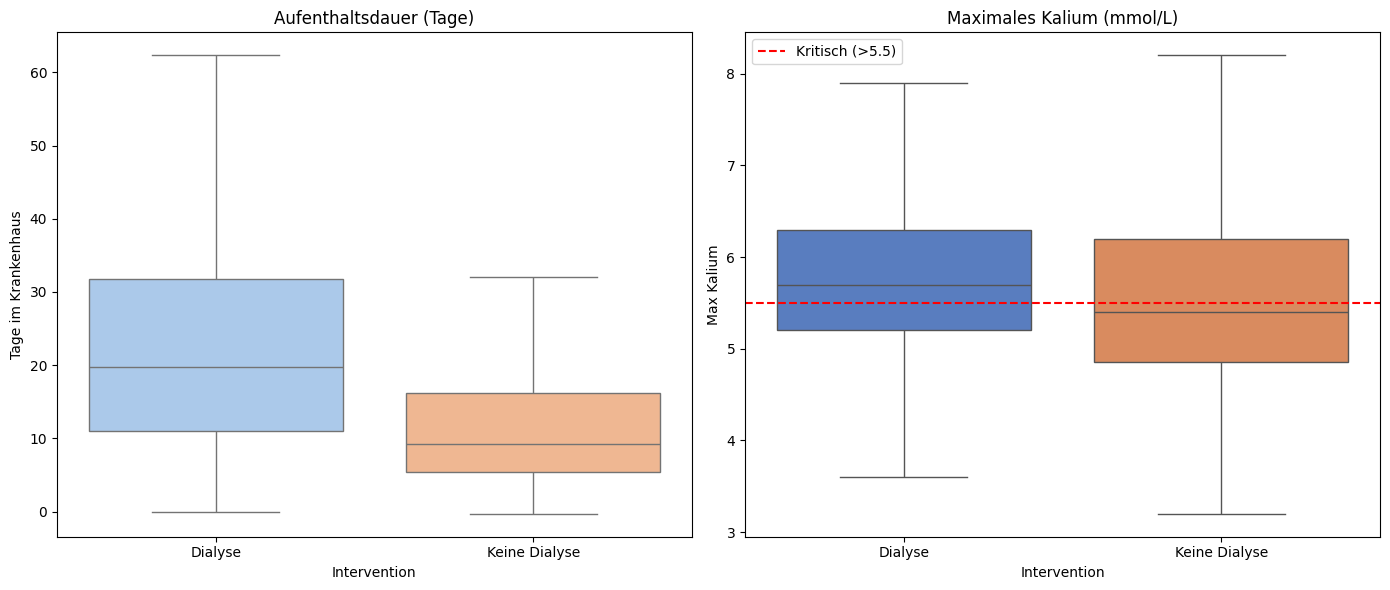

los_days max_potassium        outcome_death
                median          mean median          mean
Intervention                                             
Dialyse          19.70          5.85    5.7          0.29
Keine Dialyse     9.16          5.62    5.4          0.32

In [17]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('..'))
from src.db_connect import load_sql, get_engine, text

# 1. Basis-Daten laden (inkl. Schweregrade aus dem vorherigen Schritt)
print("Lade Basis-Daten...")
# Wir nutzen hier wieder die Query, die wir schon hatten, oder laden direkt die Tabelle
# Der Einfachheit halber bauen wir die Query hier kurz zusammen:
engine = get_engine()
with engine.connect() as conn:
    # Wir laden die Kohorte + Kreatinin (via SQL String Verknüpfung wäre sauberer, 
    # aber wir machen es hier via Pandas Merge, das ist einfacher zu verstehen)
    df_cohort = pd.read_sql("SELECT * FROM cohort_aki", conn)
    
    # Kreatinin dazu laden (das hatten wir in add_severity.sql)
    # Wir laden die SQL Datei von vorhin einfach nochmal
    with open('../sql/add_severity.sql', 'r') as f:
        query_sev = f.read()
    df_severity = pd.read_sql(text(query_sev), conn)

# 2. Kalium dazu laden
print("Lade Kalium-Werte...")
df_pot = load_sql('../sql/get_potassium.sql')

# 3. Alles zusammenfügen (Mergen)
# df_severity hat schon alles wichtige, wir packen Kalium dazu
full_df = pd.merge(df_severity, df_pot, on='hadm_id', how='left')

# 4. Filter auf die "Schwere Gruppe" (Kreatinin > 4), wie Sie es eben hatten
risk_group = full_df[ full_df['max_creatinine'] > 4.0 ].copy()

# Label für Plotting
risk_group['Intervention'] = risk_group['intervention_dialysis'].map({0: 'Keine Dialyse', 1: 'Dialyse'})

print(f"Analyse basiert auf {len(risk_group)} Hochrisiko-Patienten.")

# --- VISUALISIERUNG ---

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Aufenthaltsdauer (LOS)
sns.boxplot(x='Intervention', y='los_days', data=risk_group, ax=axes[0], palette='pastel', showfliers=False)
axes[0].set_title('Aufenthaltsdauer (Tage)')
axes[0].set_ylabel('Tage im Krankenhaus')

# Plot 2: Kalium
sns.boxplot(x='Intervention', y='max_potassium', data=risk_group, ax=axes[1], palette='muted', showfliers=False)
axes[1].set_title('Maximales Kalium (mmol/L)')
axes[1].set_ylabel('Max Kalium')
# Linie für gefährliches Kalium (Hyperkaliämie > 5.5)
axes[1].axhline(y=5.5, color='red', linestyle='--', label='Kritisch (>5.5)')
axes[1].legend()

plt.tight_layout()
plt.show()

# --- TABELLE ---
stats = risk_group.groupby('Intervention').agg({
    'los_days': 'median',
    'max_potassium': ['mean', 'median'],
    'outcome_death': 'mean' # Zur Erinnerung
}).round(2)

display(stats)

Analyse der Überlebenden: 1620 Patienten


C:\Users\Simon\AppData\Local\Temp\ipykernel_38236\91129701.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


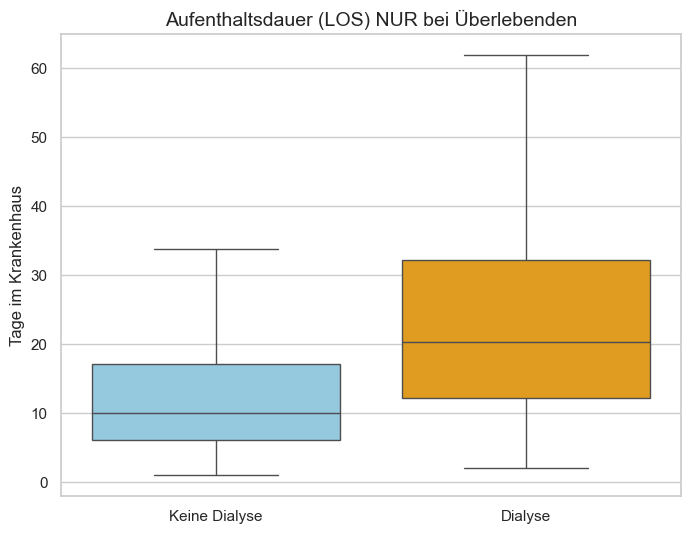

Vergleich der Aufenthaltsdauer (nur Überlebende):


,Median (Tage),Mittelwert (Tage),Min,Max
Intervention,,,,
Dialyse,20.2,25.0,2.0,153.9
Keine Dialyse,9.9,13.9,1.0,112.8


In [18]:
# Wir nehmen die Hochrisiko-Gruppe (Kreatinin > 4) von vorhin
# und filtern NUR die Überlebenden (outcome_death == 0)
survivors = risk_group[ risk_group['outcome_death'] == 0 ].copy()

print(f"Analyse der Überlebenden: {len(survivors)} Patienten")

# --- VISUALISIERUNG ---
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")

# Boxplot nur für Überlebende
sns.boxplot(
    x='Intervention', 
    y='los_days', 
    data=survivors, 
    palette=['skyblue', 'orange'],
    showfliers=False # Ausreißer ausblenden, damit man den Median besser sieht
)

plt.title('Aufenthaltsdauer (LOS) NUR bei Überlebenden', fontsize=14)
plt.ylabel('Tage im Krankenhaus')
plt.xlabel('')
plt.show()

# --- TABELLE ---
los_stats = survivors.groupby('Intervention')['los_days'].agg(['median', 'mean', 'min', 'max']).round(1)
los_stats.columns = ['Median (Tage)', 'Mittelwert (Tage)', 'Min', 'Max']

print("Vergleich der Aufenthaltsdauer (nur Überlebende):")
display(los_stats)

Lade Vorerkrankungen (CKD & Krebs)...
Patienten VOR Filterung: 11414
Patienten NACH Filterung: 7236
Entfernt: 4178 Patienten

--- Ergebnis der BEREINIGTEN Kohorte (Krea > 4, kein Krebs/CKD) ---


,Sterblichkeit (%),Anzahl (N),LOS Median,Kreatinin Median
Keine Dialyse,33.0,781,9.59,5.1
Dialyse,32.0,492,20.64,6.4


C:\Users\Simon\AppData\Local\Temp\ipykernel_38236\3233625484.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=clean_risk['intervention_dialysis'], y=clean_risk['outcome_death'], palette=['skyblue', 'orange'])


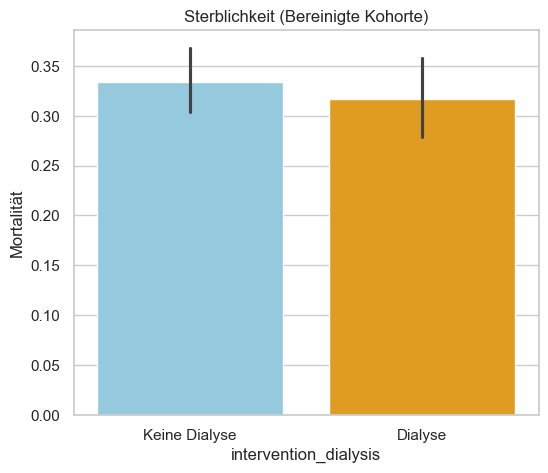

In [19]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.abspath('..'))
from src.db_connect import load_sql, get_engine, text

# 1. Basis-Daten laden (Unsere Tabelle)
engine = get_engine()
with engine.connect() as conn:
    df_cohort = pd.read_sql("SELECT * FROM cohort_aki", conn)
    
    # Dazu noch das Kreatinin laden (für den Schweregrad-Check)
    with open('../sql/add_severity.sql', 'r') as f:
        query_sev = f.read()
    df_sev = pd.read_sql(text(query_sev), conn)

# 2. Ausschluss-Kriterien laden
print("Lade Vorerkrankungen (CKD & Krebs)...")
df_exclude = load_sql('../sql/exclusions.sql')

# 3. Alles verknüpfen
full_df = pd.merge(df_cohort, df_exclude, on='hadm_id', how='left')
# Kreatinin dazu
full_df = pd.merge(full_df, df_sev[['hadm_id', 'max_creatinine']], on='hadm_id', how='left')

# Fehlende Werte bei Ausschlusskriterien sind 0 (Gesund)
full_df['has_ckd'] = full_df['has_ckd'].fillna(0)
full_df['has_cancer'] = full_df['has_cancer'].fillna(0)

# --- FILTERUNG ---
print(f"Patienten VOR Filterung: {len(full_df)}")

# Wir schließen aus:
clean_df = full_df[
    (full_df['has_ckd'] == 0) &      # Keine chronische Nierenkrankheit
    (full_df['has_cancer'] == 0)     # Kein metastasierender Krebs
].copy()

print(f"Patienten NACH Filterung: {len(clean_df)}")
print(f"Entfernt: {len(full_df) - len(clean_df)} Patienten")

# --- ERNEUTE ANALYSE DER HOCHRISIKO-GRUPPE ---

# Wir schauen uns jetzt wieder die "Schwerkranken" an (Krea > 4), aber diesmal ohne Krebs/CKD
clean_risk = clean_df[ clean_df['max_creatinine'] > 4.0 ].copy()

stats = clean_risk.groupby('intervention_dialysis').agg({
    'outcome_death': ['mean', 'count'],
    'los_days': 'median',
    'max_creatinine': 'median'
}).round(2)

stats.columns = ['Sterblichkeit (%)', 'Anzahl (N)', 'LOS Median', 'Kreatinin Median']
stats.index = ['Keine Dialyse', 'Dialyse']
# Prozent umrechnen
stats['Sterblichkeit (%)'] = stats['Sterblichkeit (%)'] * 100

print("\n--- Ergebnis der BEREINIGTEN Kohorte (Krea > 4, kein Krebs/CKD) ---")
display(stats)

# Visualisierung
plt.figure(figsize=(6, 5))
sns.barplot(x=clean_risk['intervention_dialysis'], y=clean_risk['outcome_death'], palette=['skyblue', 'orange'])
plt.title('Sterblichkeit (Bereinigte Kohorte)')
plt.xticks([0, 1], ['Keine Dialyse', 'Dialyse'])
plt.ylabel('Mortalität')
plt.show()